In [ ]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.integrate import quad
import scipy.integrate as integrate

# Loading the data from the uploaded file
file_path = "merged_data.csv"  # Path to the uploaded data file
data = pd.read_csv(file_path)
# Displaying the first few rows of the data to understand its structure
data.head()

,ts_event,bid_fill,ask_fill,Signed Volume,price,best_bid,best_ask,mid_price
0,2024-10-22 08:00:00,801.0,1999.0,-1198.0,236.14,235.83,236.14,235.985
1,2024-10-22 08:00:01,201.0,202.0,-1.0,236.13,235.83,236.13,235.980
2,2024-10-22 08:00:02,1600.0,1400.0,200.0,235.83,235.83,236.11,235.970
3,2024-10-22 08:00:03,534.0,400.0,134.0,236.10,235.96,236.10,236.030
4,2024-10-22 08:00:04,400.0,502.0,-102.0,236.11,235.96,236.11,236.035


### Part 1: Construct and code the linear OW model and nonlinear AFS model, and visualize the distribution of price impact based on the given data. (33 pt)

## Linear Model of Obizhaeva and Wang (2013)

### Model Formula
The linear OW model calculates price impact using the following formula:

$$
J_t = \int_0^t e^{-\beta (t-s)} dQ_s
$$


> Add blockquote


- **$J_t$**: Cumulative price impact at time $t$.
- **$e^{-\beta (t-s)}$**: Exponential decay kernel, describing how past transactions contribute less to the current price impact as time increases.
- **$Q_s$**: Transaction volume at time $s$.

### Parameter Explanation
1. **$\lambda$** (Price Impact Coefficient):
   - A linear scaling factor controlling the magnitude of price impact per unit of transaction volume.
   - Simulates different sensitivities of markets to trading impacts.

2. **$\beta$** (Decay Rate):
   - A parameter of the exponential kernel controlling the weight of past trades.
   - **Lower $\beta$**: Past trades have a larger influence on the current price impact.
   - **Higher $\beta$**: Influence of past trades diminishes rapidly.

3. **Output: Price Impact Distribution**:
   - The model computes and visualizes the distribution of price impacts using combinations of $\beta$ and $\lambda$ values.



In [ ]:
### parameters
beta_values = [0.01, 0.1, 1.0]  # Larger magnitude differences for decay rates
lambda_values = [0.3, 0.5, 0.8]  # Keeping lambda values consistent

# Converting timestamp to datetime and calculating time deltas
data['timestamp'] = pd.to_datetime(data['ts_event'])
data['time_delta'] = (data['timestamp'] - data['timestamp'].min()).dt.total_seconds()
data['cumulative_volume'] = data['Signed Volume'].cumsum()

# # Initialize a column to store the price impact
# data['price_impact'] = 0.0

# # Loop over each row to calculate cumulative price impact
# for i in tqdm(range(len(data)), desc="Calculating Price Impact"):
#     current_time = data['time_delta'].iloc[i]
#     # Calculate time differences (t - s) for all past transactions
#     time_differences = current_time - data['time_delta'].iloc[:i+1]
#     # Apply exponential decay kernel
#     weights = np.exp(-beta * time_differences)
#     # Compute cumulative weighted price impact
#     data.loc[data.index[i], 'price_impact'] = lambda_ * np.sum(weights * data['Signed Volume'].iloc[:i+1])


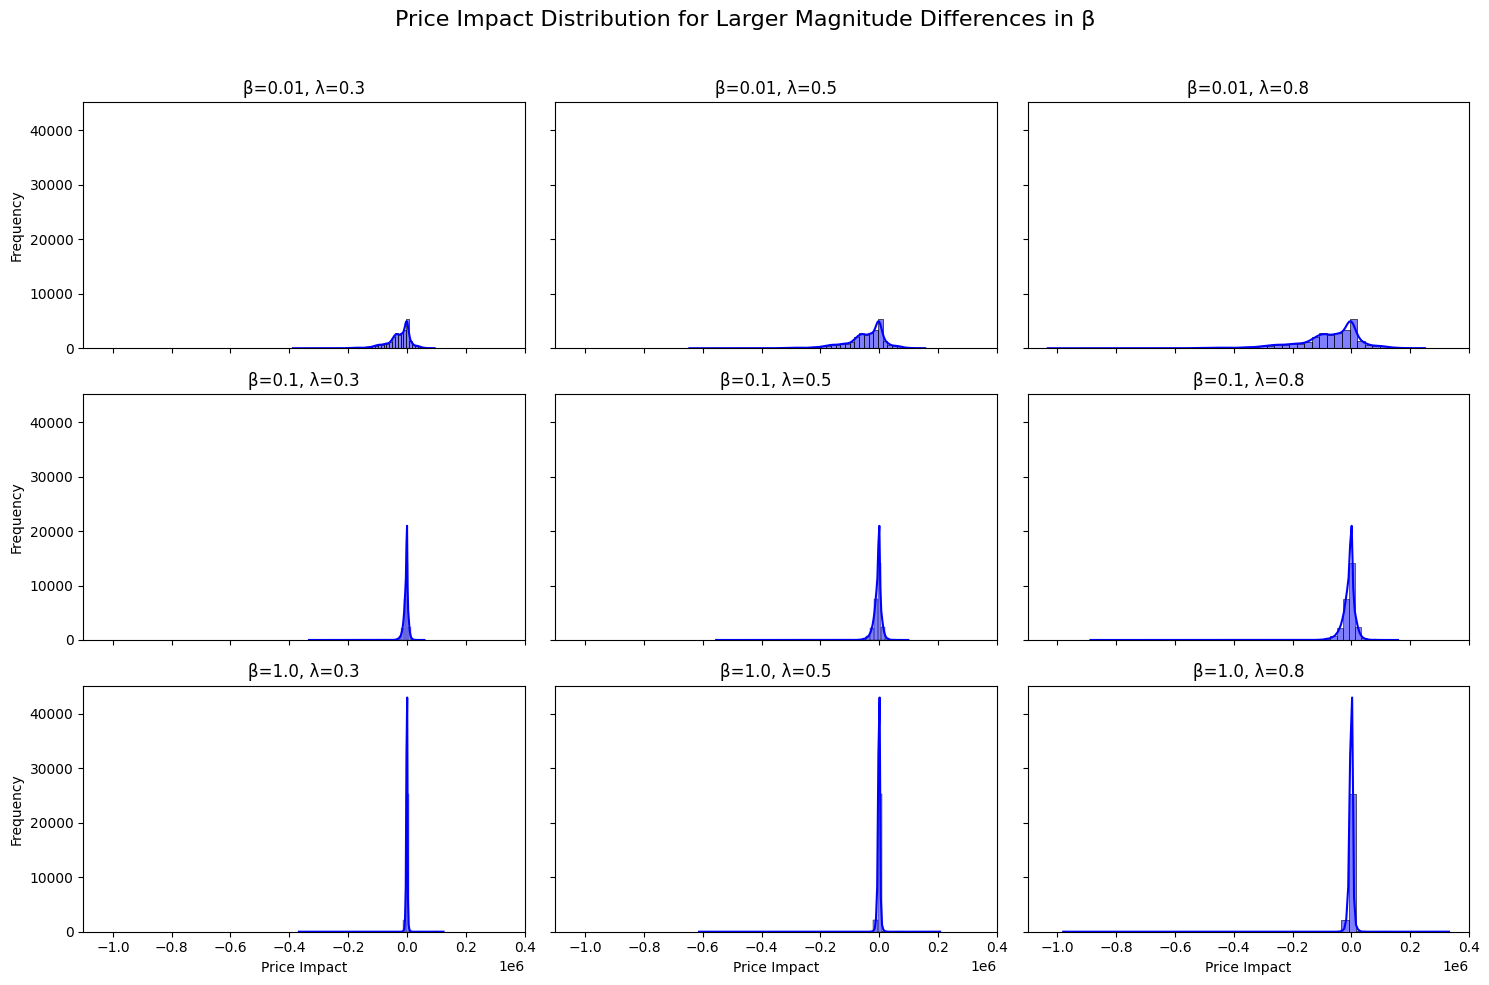

In [ ]:
# Pre-compute time_delta and Signed Volume as arrays for performance
time_delta = data['time_delta'].values
signed_volume = data['Signed Volume'].values

# Create grid plots
fig, axes = plt.subplots(len(beta_values), len(lambda_values), figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Price Impact Distribution for Larger Magnitude Differences in β', fontsize=16)

# Compute and visualize price impacts
for i, beta in enumerate(beta_values):
    for j, lambda_ in enumerate(lambda_values):
        # Compute price impact for the current combination
        price_impact = np.zeros(len(time_delta))
        for k in range(len(time_delta)):
            time_differences = time_delta[k] - time_delta[:k+1]
            weights = np.exp(-beta * time_differences)
            price_impact[k] = lambda_ * np.sum(weights * signed_volume[:k+1])

        # Plot the price impact distribution
        ax = axes[i, j]
        sns.histplot(price_impact, bins=50, kde=True, ax=ax, color='blue')
        ax.set_title(f'β={beta}, λ={lambda_}', fontsize=12)
        ax.set_xlabel('Price Impact', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Figure Analysis and Observations

### Description of the Output
- The **x-axis** represents the magnitude of the price impact.
- The **y-axis** represents the frequency of occurrences for each price impact value.
- Each subplot corresponds to a specific combination of $\beta$ (decay rate) and $\lambda$ (impact coefficient).

### Observations
1. **Effect of $\lambda$** (Column-wise):
   - Larger $\lambda$ (e.g., $0.8$) results in higher price impacts, creating broader distributions.
   - Smaller $\lambda$ (e.g., $0.3$) produces weaker price impacts, with more concentrated distributions.

2. **Effect of $\beta$** (Row-wise):
   - **Small $\beta$** (e.g., $0.01$):
     - Past trades have a significant influence, resulting in wider distributions.
   - **Large $\beta$** (e.g., $1.0$):
     - Historical trades decay quickly, focusing on recent transactions, which creates tighter distributions.

3. **Combined Effects**:
   - Small $\beta$ and large $\lambda$ (e.g., $\beta = 0.01, \lambda = 0.8$) yield the largest and broadest price impacts.
   - Large $\beta$ and small $\lambda$ (e.g., $\beta = 1.0, \lambda = 0.3$) result in the smallest, most concentrated price impacts.

### Conclusion
By adjusting $\beta$ and $\lambda$, the model can simulate price impact behaviors under varying market conditions. Small $\beta$ with large $\lambda$ fits scenarios involving large institutional trades causing significant impact, while large $\beta$ better represents high-frequency trading with rapid impact decay.



## Nonlinear Model of Alfonsi, Fruth, and Schied (2010)

### Model Formula
The nonlinear price impact model is defined as:

$$
J_t = \int_0^t e^{-\beta (t-s)} \cdot \text{sign}(Q_s) \cdot |Q_s|^p \, dQ_s
$$

- **$J_t$**: Cumulative price impact at time $t$.
- **$e^{-\beta (t-s)}$**: Exponential decay kernel, describing how past transactions contribute less to the current price impact as time increases.
- **$\text{sign}(Q_s)$**: Direction of the trade (positive for buy, negative for sell).
- **$|Q_s|^p$**: Nonlinear power-law relationship between trade size and price impact, where $p \in (0, 1]$.

### Parameter Explanation
1. **$\lambda$** (Price Impact Coefficient):
   - A scaling factor controlling the magnitude of price impact per unit of transaction volume.
   - Simulates different market sensitivities to trading impacts.

2. **$\beta$** (Decay Rate):
   - Controls the influence of past trades, where lower $\beta$ implies slower decay and higher $\beta$ implies faster decay.

3. **$p$** (Nonlinear Exponent):
   - Determines the nonlinearity of the impact:
     - $p=1.0$: Linear price impact (reduces to the OW model).
     - $p < 1.0$: Sublinear impact, following a power-law behavior.

4. **Output: Price Impact Distribution**:
   - Visualizes how different combinations of $p$, $\beta$, and $\lambda$ affect the distribution of price impacts.


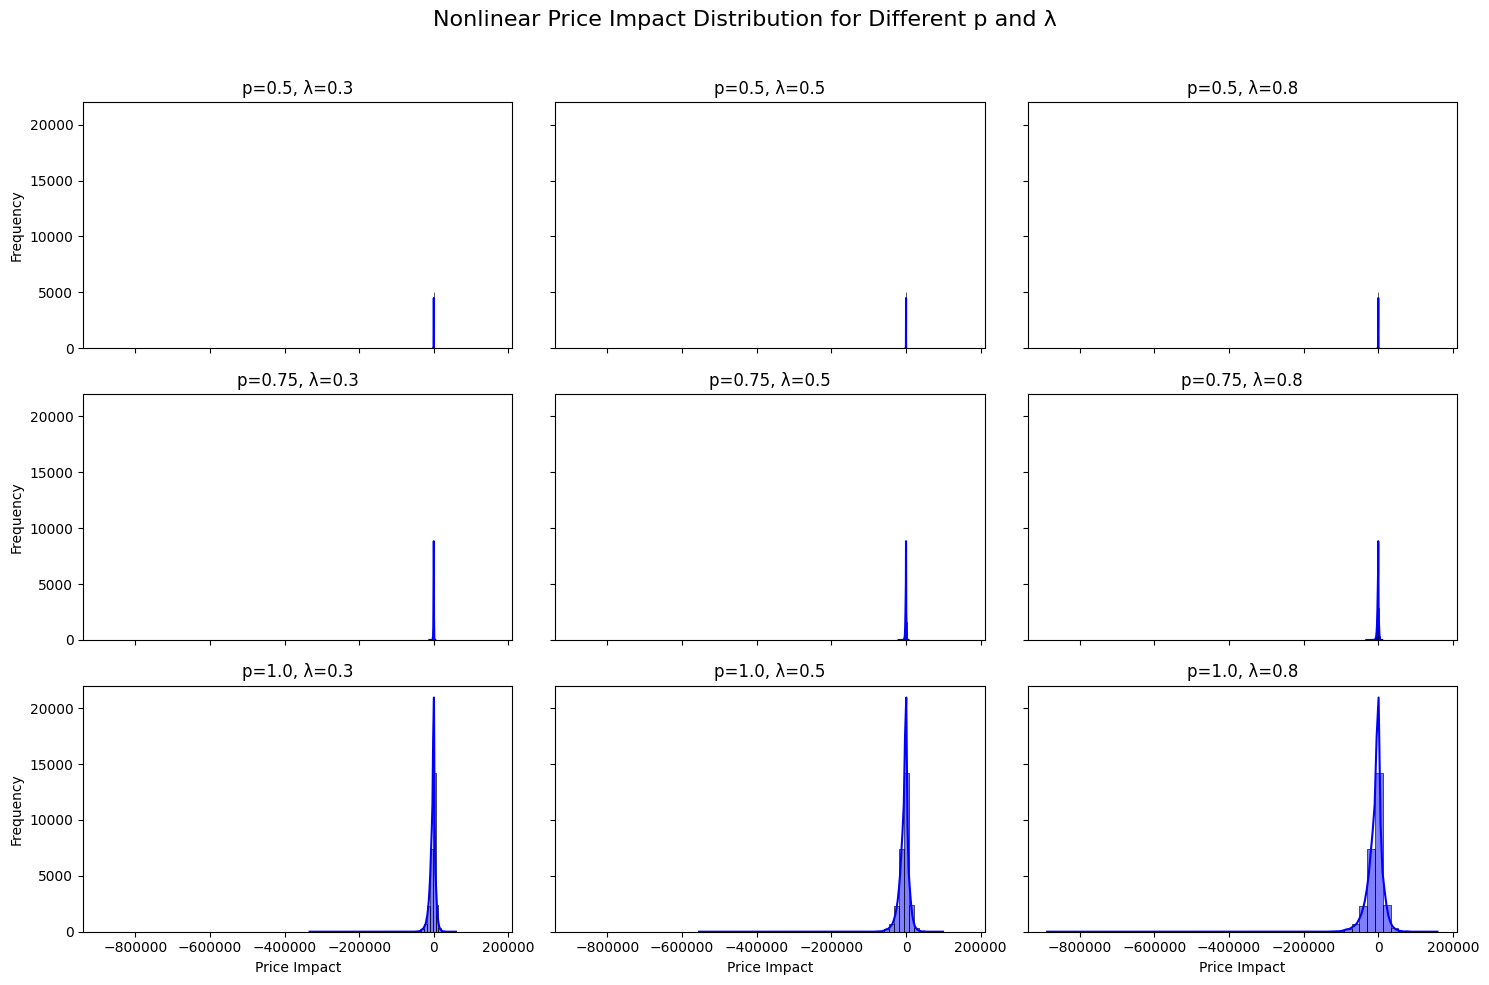

In [ ]:
lambda_values = [0.3, 0.5, 0.8]  # Different impact coefficients
beta_values = [0.01, 0.1, 1.0]   # Decay rates
p_values = [0.5, 0.75, 1.0]      # Nonlinear exponent values (p)

# Create grid plots for nonlinear price impact model
fig, axes = plt.subplots(len(p_values), len(lambda_values), figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Nonlinear Price Impact Distribution for Different p and λ', fontsize=16)

# Compute and visualize price impacts for nonlinear model
for i, p in enumerate(p_values):
    for j, lambda_ in enumerate(lambda_values):
        # Compute price impact for the current combination
        price_impact = np.zeros(len(time_delta))
        for k in range(len(time_delta)):
            time_differences = time_delta[k] - time_delta[:k+1]
            weights = np.exp(-beta_values[1] * time_differences)  # Use a fixed β for this analysis
            price_impact[k] = lambda_ * np.sum(weights * np.sign(signed_volume[:k+1]) * np.abs(signed_volume[:k+1])**p)

        # Plot the price impact distribution
        ax = axes[i, j]
        sns.histplot(price_impact, bins=50, kde=True, ax=ax, color='blue')
        ax.set_title(f'p={p}, λ={lambda_}', fontsize=12)
        ax.set_xlabel('Price Impact', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Figure Analysis and Observations

### Description of the Output
- The **x-axis** represents the magnitude of the price impact.
- The **y-axis** represents the frequency of occurrences for each price impact value.
- Each subplot corresponds to a specific combination of $p$ (nonlinear exponent) and $\lambda$ (impact coefficient).

### Observations
1. **Effect of $p$ (Row-wise)**:
   - **$p=1.0$**:
     - Price impact behaves linearly, similar to the OW model, with broader distributions for larger impacts.
   - **$p=0.75$**:
     - Sublinear impact reduces the sensitivity to large trades, resulting in narrower distributions.
   - **$p=0.5$**:
     - Strongly sublinear impact heavily dampens large trades, concentrating impacts near zero.

2. **Effect of $\lambda$ (Column-wise)**:
   - Larger $\lambda$ (e.g., $0.8$) amplifies the magnitude of price impacts, resulting in broader distributions.
   - Smaller $\lambda$ (e.g., $0.3$) results in weaker impacts, concentrating distributions near zero.

3. **Combined Effects**:
   - Small $p$ and large $\lambda$ (e.g., $p=0.5$, $\lambda=0.8$) yield the most controlled impacts, limiting outliers.
   - Large $p$ and small $\lambda$ (e.g., $p=1.0$, $\lambda=0.3$) closely resemble the linear model with minimal scaling.

### Conclusion
The nonlinear model captures the sublinear nature of price impact seen in real markets, where large trades often have a reduced marginal effect. By adjusting $p$, $\lambda$, and $\beta$, the model can flexibly simulate varying market conditions.


### Part 2: Implement and code the optimal strategy with Linear Impact and visualize the Sharpe Ratio plots in Section 6.2. (33 pt)

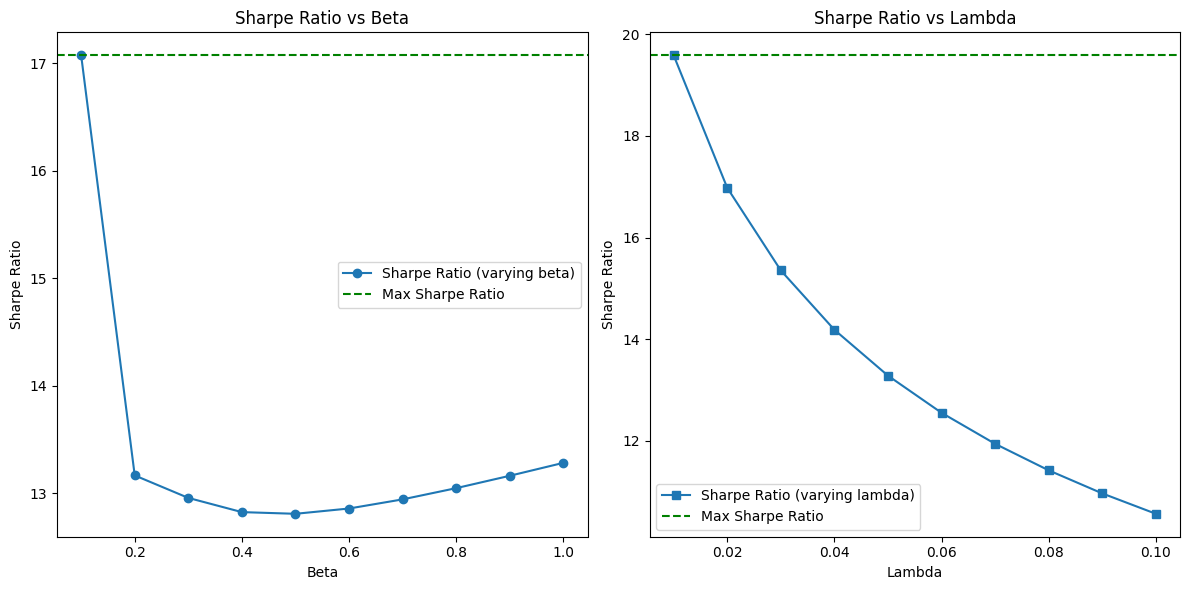

In [ ]:
# Constants and Parameters
gamma = 0.1
sigma = 0.2
alpha = 0.5
phi = 0.3
beta = 0.4
lambd = 0.05
N = 10  # Number of kernels

# Exponential kernel and its derivatives
def K(t, beta):
    return np.exp(-beta * t)

def K_prime(t, beta):
    return -beta * np.exp(-beta * t)

def K_double_prime(t, beta):
    return beta**2 * np.exp(-beta * t)

# Rho function
def rho_function(t, C1, C2, phi, gamma, beta, sigma):
    xi = np.sqrt(gamma * sigma**2 * (gamma * sigma**2 + 2 * lambd * beta))
    return C1 * np.exp(-phi * t) - C2 * np.exp(-gamma * beta * sigma**2 * t / xi)

# PnL First Term
def pnl_first_term(alpha, gamma, sigma, beta, phi, lambd):
    xi = np.sqrt(gamma * sigma**2 * (gamma * sigma**2 + 2 * lambd * beta))
    numerator = alpha**2 * gamma * sigma**2 * (beta / phi + 1)**2
    denominator = (beta * gamma * sigma**2 + xi * phi)**2
    return numerator / denominator

# Sigma_n_squared calculation
def sigma_n_squared(Kn, K_prime, beta, rho_function, phi, gamma, sigma, n):
    term1 = Kn**2 * rho_function(0, 1.0, 0.5, phi, gamma, beta, sigma)
    term2 = 2 * Kn * integrate.quad(
        lambda t: K_prime(t, beta) * rho_function(t, 1.0, 0.5, phi, gamma, beta, sigma), 0, np.inf
    )[0]
    term3 = integrate.dblquad(
        lambda t, s: K_prime(t, beta) * K_prime(s, beta) * rho_function(np.abs(t - s), 1.0, 0.5, phi, gamma, beta, sigma),
        0, np.inf, lambda s: 0, lambda s: np.inf
    )[0]
    return term1 + term2 + term3

# Sharpe Ratio
def sharpe_ratio(pnl, risk):
    return pnl / risk

# Generate Q_t (Linear Feedback Strategy)
def generate_Q(C_f, C_J, f_t, J_t):
    return C_f * f_t - C_J * J_t

# PnL computation
def compute_pnl(alpha, gamma, sigma, beta, phi, lambd, N):
    pnl = pnl_first_term(alpha, gamma, sigma, beta, phi, lambd)
    for n in range(1, N + 1):
        Kn = 1.0 / n
        tau_n = Kn + integrate.quad(lambda t: K_prime(t, beta), 0, np.inf)[0]
        sigma_n = sigma_n_squared(Kn, K_prime, beta, rho_function, phi, gamma, sigma, n)
        pnl += Kn * tau_n / sigma_n
    return pnl

# Main Execution
beta_values = np.linspace(0.1, 1.0, 10)
lambda_values = np.linspace(0.01, 0.1, 10)
sharpe_ratios_beta = []
sharpe_ratios_lambda = []

# Fix lambda, vary beta
for beta in beta_values:
    pnl = compute_pnl(alpha, gamma, sigma, beta, phi, lambd, N)
    risk = np.sqrt(pnl)  # Assume risk is proportional to sqrt(PnL)
    sharpe_ratios_beta.append(sharpe_ratio(pnl, risk))

# Fix beta, vary lambda
for lambd in lambda_values:
    pnl = compute_pnl(alpha, gamma, sigma, beta, phi, lambd, N)
    risk = np.sqrt(pnl)
    sharpe_ratios_lambda.append(sharpe_ratio(pnl, risk))


# Visualization of Sharpe Ratios
def plot_sharpe_ratios(beta_values, lambda_values, sharpe_ratios_beta, sharpe_ratios_lambda):
    plt.figure(figsize=(12, 6))

    # Plot Sharpe Ratio vs Beta
    plt.subplot(1, 2, 1)
    plt.plot(beta_values, sharpe_ratios_beta, marker='o', label="Sharpe Ratio (varying beta)")
    plt.axhline(y=max(sharpe_ratios_beta), color='green', linestyle='--', label='Max Sharpe Ratio')
    plt.xlabel("Beta")
    plt.ylabel("Sharpe Ratio")
    plt.title("Sharpe Ratio vs Beta")
    plt.legend()

    # Plot Sharpe Ratio vs Lambda
    plt.subplot(1, 2, 2)
    plt.plot(lambda_values, sharpe_ratios_lambda, marker='s', label="Sharpe Ratio (varying lambda)")
    plt.axhline(y=max(sharpe_ratios_lambda), color='green', linestyle='--', label='Max Sharpe Ratio')
    plt.xlabel("Lambda")
    plt.ylabel("Sharpe Ratio")
    plt.title("Sharpe Ratio vs Lambda")
    plt.legend()

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_sharpe_ratios(beta_values, lambda_values, sharpe_ratios_beta, sharpe_ratios_lambda)


### Part 3: Implement and code the Deep Learning Algorithm in for discrete setting in Appendix C.2 and visualize the training loss for different network structures in Appendix C.2. (33 pt)

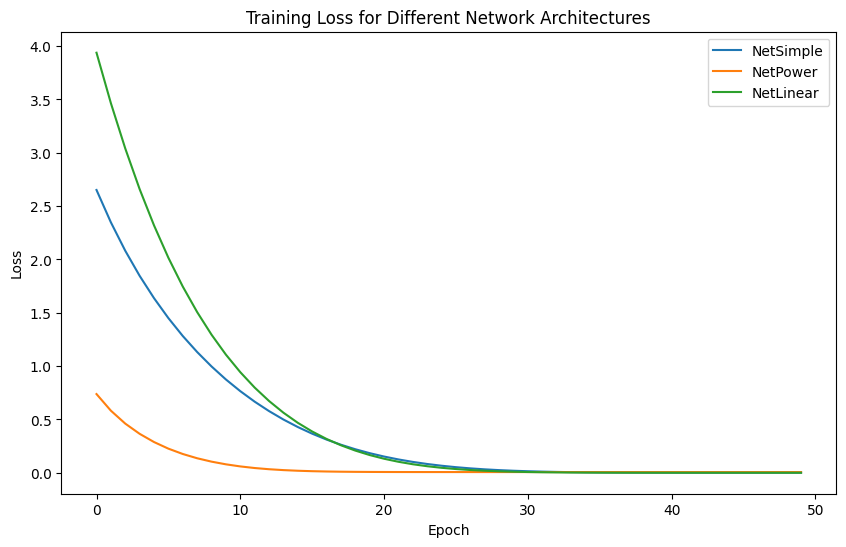

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define Neural Network Architectures
class NetSimple(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NetSimple, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)

class NetPower(nn.Module):
    def __init__(self, input_dim, output_dim, p=1):
        super(NetPower, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        x = self.fc(x)
        B = 1.0  # Set boundary value for nonlinearity
        return torch.where(torch.abs(x) < B, torch.sign(x) * torch.abs(x) ** (1 / self.p), x)

class NetLinear(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NetLinear, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)

# Hyperparameters
input_dim = 2  # (f_{n-1}, J^0_{n-1})
output_dim = 1  # Q^\theta_n
lr = 0.001
epochs = 50
batch_size = 64
N = 5120

# Generate synthetic data
np.random.seed(42)
torch.manual_seed(42)
f_n_minus_1 = np.random.randn(N, 1)
J0_n_minus_1 = np.random.randn(N, 1)
inputs = np.hstack((f_n_minus_1, J0_n_minus_1))

# Target outputs (simulated for training)
def generate_targets(inputs):
    f_n_minus_1, J0_n_minus_1 = inputs[:, 0], inputs[:, 1]
    return f_n_minus_1 - J0_n_minus_1  # Placeholder target (adjust based on optimization details)

targets = generate_targets(inputs).reshape(-1, 1)

# Convert to PyTorch tensors
inputs = torch.tensor(inputs, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)

# DataLoader
train_dataset = torch.utils.data.TensorDataset(inputs, targets)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Instantiate models
nets = {
    "NetSimple": NetSimple(input_dim, output_dim),
    "NetPower": NetPower(input_dim, output_dim, p=1.5),
    "NetLinear": NetLinear(input_dim, output_dim)
}

loss_fn = nn.MSELoss()

# Training loop
def train_model(model, optimizer, train_loader, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_inputs, batch_targets in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = loss_fn(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_inputs.size(0)
        epoch_loss /= len(train_loader.dataset)
        losses.append(epoch_loss)
    return losses

losses_dict = {}

for name, net in nets.items():
    optimizer = optim.Adam(net.parameters(), lr=lr)
    losses = train_model(net, optimizer, train_loader, epochs)
    losses_dict[name] = losses

# Plot training loss
plt.figure(figsize=(10, 6))
for name, losses in losses_dict.items():
    plt.plot(losses, label=name)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss for Different Network Architectures")
plt.legend()
plt.show()

